To do: remove coins that have lack of history.  Many do not exist before 2021.

In [1]:
import portfolio_utils as pu
import constants as c

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

In [2]:
symbols = c.symbols_top5exbtceth

#Select Rebalance Dates in constants file


#Portfolio Start and Stop Dates
start="2020-10-01" 
endp1="2021-11-01"

# some nice code curtesy of Kevin
agg_data = list()

crypto = pu.get_data(symbols, c.stems)#pd.read_csv(data_path)#, index_col="tradeDate")

crypto.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Base asset volume,Number of trades,Taker buy volume,Taker buy base asset volume,Ignore,symbol,Open_time_,Close_time_
26,1635292800000,44.93,45.77,38.70,40.44,17560562.15,1635379199999,7.385268e+08,1215968,8364728.14,3.517158e+08,0,DOTUSDT,2021-10-27,2021-10-27 23:59:59.999
27,1635379200000,40.43,43.12,39.81,41.82,11629300.38,1635465599999,4.869381e+08,726484,5755440.09,2.410635e+08,0,DOTUSDT,2021-10-28,2021-10-28 23:59:59.999
28,1635465600000,41.82,44.35,41.56,44.20,8788034.21,1635551999999,3.792516e+08,560104,4515467.67,1.949316e+08,0,DOTUSDT,2021-10-29,2021-10-29 23:59:59.999
29,1635552000000,44.19,44.31,42.08,42.73,5254551.32,1635638399999,2.263268e+08,339208,2477892.42,1.067457e+08,0,DOTUSDT,2021-10-30,2021-10-30 23:59:59.999
30,1635638400000,42.73,43.36,41.01,42.77,6375433.77,1635724799999,2.680942e+08,390771,3124574.16,1.313894e+08,0,DOTUSDT,2021-10-31,2021-10-31 23:59:59.999


In [3]:
symbols

['XRPUSDT', 'ADAUSDT', 'BNBUSDT', 'SOLUSDT', 'DOTUSDT']

In [4]:
crypto.shape

(2130, 15)

In [6]:
crypto_ = crypto[["Close_time_", "symbol", "Close"]] #crypto_ = crypto[["tradeDate", "symbol", "avg_latest"]]
crypto_.columns=["tradeDate", "symbol", "Close"]
crypto_ = crypto_.pivot_table(index="tradeDate", columns="symbol", values = "Close")
crypto2_ = crypto_.pct_change()
crypto2_ = crypto2_[1:]
crypto2_.head()

symbol,ADAUSDT,BNBUSDT,DOTUSDT,SOLUSDT,XRPUSDT
tradeDate,,,,,
2020-09-02 23:59:59.999,-0.076818,0.002526,-0.016285,-0.039104,-0.065242
2020-09-03 23:59:59.999,-0.177822,-0.177911,-0.075455,-0.159448,-0.115456
2020-09-04 23:59:59.999,0.075164,0.030060,-0.100876,0.007132,0.039985
2020-09-05 23:59:59.999,-0.113824,-0.071593,-0.187440,-0.262004,-0.064881
2020-09-06 23:59:59.999,0.028889,0.188610,0.153995,0.187663,0.010447


In [7]:
sim_sum=10000
initial_investment = 10000
#potfolio_SR = np.zeros(sim_sum)
a = np.zeros(((sim_sum,len(symbols))))
portfolio_df = pd.DataFrame(a)
portfolio_df.columns = symbols
portfolio_df["Portfolio_SR"] = -999

for i in tqdm(range(sim_sum)):
    symbol_count = random.randint(2,len(symbols))
    symbol_sublist = random.sample(symbols, symbol_count)
    portfolio_weights = np.random.dirichlet(np.ones(symbol_count))

    df = crypto2_[symbol_sublist]
    clean_return_history = df.reset_index(drop=True)
    clean_return_history['date']=pu.date_cleaner(pd.Series(crypto2_.index.values).astype(str))
    
    # Instantiate the portfolio object
    portfolio_obj = pu.Portfolio(
        data=clean_return_history, 
        symbols=symbol_sublist, 
        weights=portfolio_weights, 
        initial_investment=initial_investment,
        start_date=start,
        end_date=endp1, 
        rebalance_dates=c.rebalance_dates)
    # estimate returns
    portfolio_obj.estimate_portfolio_returns()
    #print(portfolio_obj.get_sharpe_report())
    portfolio_df.loc[i,symbol_sublist] = portfolio_weights
    portfolio_df.loc[i,"Portfolio_SR"] = portfolio_obj.get_sharpe_ratio()
portfolio_df.to_csv(
    "data/random_portfolios_"+min(crypto.Close_time_.astype(str))+"_to_"+max(crypto.Close_time_.astype(str))+".csv", index=False)

100%|██████████| 10000/10000 [24:42<00:00,  6.74it/s]


In [12]:
# equal weight portfolio
portfolio_weights = np.ones(len(symbols))/len(symbols)

df = crypto2_[symbols]
clean_return_history = df.reset_index(drop=True)
clean_return_history['date']=pu.date_cleaner(pd.Series(crypto2_.index.values).astype(str))

# Instantiate the portfolio object
portfolio_obj = pu.Portfolio(
    data=clean_return_history, 
    symbols=symbols, 
    weights=portfolio_weights, 
    initial_investment=initial_investment,
    start_date=start,
    end_date=endp1, 
    rebalance_dates=c.rebalance_dates)
# estimate returns
portfolio_obj.estimate_portfolio_returns()
#print(portfolio_obj.get_sharpe_report())

equal_wt_SR = portfolio_obj.get_sharpe_ratio()
equal_wt_SR

3.2804741052969164

Text(0.5, 1.0, 'ADAUSDT,BNBUSDT,DOTUSDT,SOLUSDT,XRPUSDT')

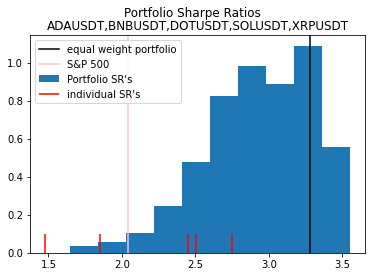

In [23]:
#clean_return_history
ind_SR = np.sqrt(365)*np.mean(crypto2_, axis=0)/np.std(crypto2_, axis=0)
_=plt.hist(portfolio_df["Portfolio_SR"], label="Portfolio SR's", density=True)
plt.vlines(x=ind_SR[symbols],ymin=0, ymax=.1, color="red", label="individual SR's")
plt.axvline(equal_wt_SR, label="equal weight portfolio", color='black')
plt.axvline(2.04, label="S&P 500",color='pink')

_=plt.legend()
plt.suptitle("Portfolio Sharpe Ratios")
plt.title("ADAUSDT,BNBUSDT,DOTUSDT,SOLUSDT,XRPUSDT")

In [9]:
portfolio_df.loc[portfolio_df.Portfolio_SR>max(ind_SR[symbols]),:].shape

(7097, 6)

In [10]:
portfolio_df.sort_values(by=['Portfolio_SR'],ascending=False).head(500)

,XRPUSDT,ADAUSDT,BNBUSDT,SOLUSDT,DOTUSDT,Portfolio_SR
1221,0.047218,0.418400,0.079499,0.454883,0.000000,3.551202
8046,0.044058,0.388625,0.081398,0.485919,0.000000,3.549637
5859,0.067880,0.392893,0.063949,0.432361,0.042917,3.543727
7700,0.000000,0.364977,0.159712,0.475311,0.000000,3.543723
3326,0.000000,0.373777,0.171300,0.454923,0.000000,3.543622
8003,0.024937,0.361046,0.117780,0.433772,0.062466,3.543421
8066,0.034690,0.424694,0.153013,0.387604,0.000000,3.543028
7622,0.000000,0.402856,0.079253,0.517890,0.000000,3.542606
4810,0.000000,0.378292,0.135860,0.431884,0.053964,3.541132
3606,0.017569,0.337573,0.136789,0.508069,0.000000,3.540790


In [11]:
crypto2_.head()

symbol,ADAUSDT,BNBUSDT,DOTUSDT,SOLUSDT,XRPUSDT
tradeDate,,,,,
2020-09-02 23:59:59.999,-0.076818,0.002526,-0.016285,-0.039104,-0.065242
2020-09-03 23:59:59.999,-0.177822,-0.177911,-0.075455,-0.159448,-0.115456
2020-09-04 23:59:59.999,0.075164,0.030060,-0.100876,0.007132,0.039985
2020-09-05 23:59:59.999,-0.113824,-0.071593,-0.187440,-0.262004,-0.064881
2020-09-06 23:59:59.999,0.028889,0.188610,0.153995,0.187663,0.010447
